In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
# Must import comet before torch, sometimes throws error otherwise.
from img_wang.callbacks import CometCallbackWithGrads
from fastai2.data.transforms import get_image_files
from fastai2.vision.all import show_image, show_images
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from htools import *
from img_wang.data import load_img, get_databunch
from img_wang.models import Encoder, SingleInputBinaryModel, \
    TorchvisionEncoder
from img_wang.utils import gpu_setup
from incendio.callbacks import MetricHistory, ModelCheckpoint, EarlyStopper
from incendio.core import Trainer
from incendio.metrics import mean_soft_prediction, percent_positive

In [5]:
cd_root()
gpu_setup()

Current directory: /storage/img-wang
Setting seeds for reproducible training.


## Cleaned up and ported DS

In [9]:
dst, dsv, dlt, dlv = get_databunch('data/imagewang-160/unsup/', 
                                   mode='patchwork', bs=64, pct_pos=.5, 
                                   max_train_len=None, max_val_len=None, 
                                   debug_mode=None)

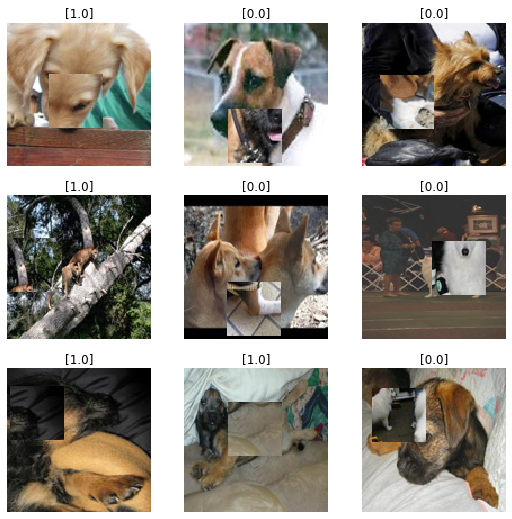

In [12]:
xb, yb = next(iter(dlt))
show_images(xb[:9], nrows=3, titles=yb[:9].tolist())

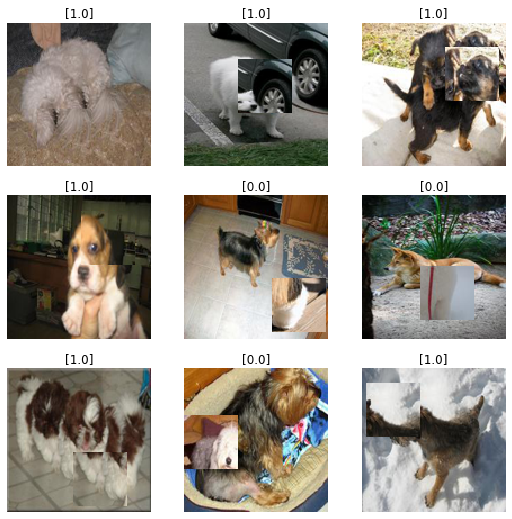

In [14]:
xv, yv = next(iter(dlv))
show_images(xv[:9], nrows=3, titles=yv[:9].tolist())

In [15]:
net = SingleInputBinaryModel(TorchvisionEncoder(), nn.Linear(2560, 1))

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


In [20]:
t = Trainer(net, dst, dsv, dlt, dlv, F.binary_cross_entropy_with_logits,
            mode='binary', out_dir='data/models/v0', last_act=torch.sigmoid,
            callbacks=[MetricHistory(None, None),
                       CometCallbackWithGrads('img_wang'),
                       ModelCheckpoint(),
                       EarlyStopper('loss', 'min', patience=5)],
            metrics=[mean_soft_prediction, percent_positive])
t.fit(50, [1e-5, 1e-4, 1e-4])

2020-09-10 05:59:05,046 [INFO]: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 0.001
    lr: 1e-05
    weight_decay: 0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 0.001
    lr: 0.0001
    weight_decay: 0

Parameter Group 2
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 0.001
    lr: 0.0001
    weight_decay: 0
)


ValueError: Comet.ml requires an API key. Please provide as the first argument to Experiment(api_key) or as an environment variable named COMET_API_KEY 

In [227]:
t.predict(xb, logits=False)

tensor([[0.3786],
        [0.3245],
        [0.3714],
        [0.4258],
        [0.5905],
        [0.3798],
        [0.3640],
        [0.3791]])

In [228]:
t.predict(xb)

tensor([[-0.4955],
        [-0.7334],
        [-0.5262],
        [-0.2989],
        [ 0.3661],
        [-0.4903],
        [-0.5580],
        [-0.4934]])

In [229]:
yb

tensor([[0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])

In [187]:
t.predict(xv, logits=False)

tensor([[1.0000],
        [1.0000]])

In [167]:
yv

tensor([[1.],
        [1.]])